In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

%matplotlib inline

### Nystrom approximation

In [18]:
def nystrom_proj(A, Omega, k, q = 0, nu = np.finfo(float).eps):
    n  = A.shape[0]
    nu = 1e2*nu*np.sqrt(n)
    
    Y = A @ Omega + nu*Omega
    B = Omega.T @ Y 
    C = np.linalg.cholesky(0.5*(B + B.T), )
     
    Z = np.linalg.solve(C, Y.T).T
    U, S, _ = np.linalg.svd(Z, full_matrices = False)
    
    u = U[:,:k]
    s = S[:k]
    
    l = np.maximum(0, s**2-nu)
    
    return u, l

### Test problem: 1D

Text(0.5, 1.0, 'Nystrom')

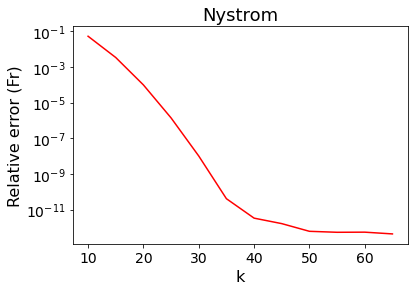

In [19]:
n = 512
x = np.linspace(0,1,n)
X,Y = np.meshgrid(x,x)
A = np.exp(-(np.abs(X-Y)/0.1)**2.)

err = []
klst = range(10,70,5)
for k in klst:
    Omega = np.random.randn(n, k+10)
    u, l = nystrom_proj(A, Omega, k)
    err_ = np.linalg.norm(u @ np.diag(l) @ u.T -A, 'fro')/np.linalg.norm(A, 'fro')
    err.append(err_)

plt.semilogy(klst, err, 'r-')
plt.xlabel('k', fontsize=16)
plt.ylabel('Relative error (Fr)', fontsize=16)
plt.title('Nystrom', fontsize = 18)

### Pivoted Cholesky

In [20]:
rng = np.random.default_rng()

def rpcholesky(A, k, method = 'rand'):
    """
    Implementation based on https://arxiv.org/pdf/2207.06503.pdf
    
    """
    d = np.diag(A).copy()
    n = d.size
    F = np.zeros((n,k), dtype = 'd')
    
    ind = []
    for i in range(k):
        if method == 'rand':
            j = rng.choice(range(n), p = d/np.sum(d))
        elif method == 'greedy':
            j = np.argmax(d)
        else:
            print('Error')
            
        ind.append(j)
        
        g = A[:,j] - F[:,:i] @ F[j,:i].T
        F[:,i] = g/np.sqrt(g[j])
        d -= np.abs(F[:,i])**2.
        
        #Adjust entries close to zero
        neg = np.nonzero(d < 0)[0]
        for k in range(neg.size):
            d[neg[k]] = 0.0 if np.abs(d[neg[k]]) < 5.e-15 else d[neg[k]]
        neg = np.nonzero(d < 0)
        
    return F, ind

/var/folders/bn/s9djwmlj7y50fp2wfldy_jpc0000gp/T/ipykernel_86608/4265721977.py:24: RuntimeWarning: divide by zero encountered in true_divide
  F[:,i] = g/np.sqrt(g[j])
/var/folders/bn/s9djwmlj7y50fp2wfldy_jpc0000gp/T/ipykernel_86608/4265721977.py:24: RuntimeWarning: invalid value encountered in true_divide
  F[:,i] = g/np.sqrt(g[j])


Text(0.5, 1.0, 'RPCholesky')

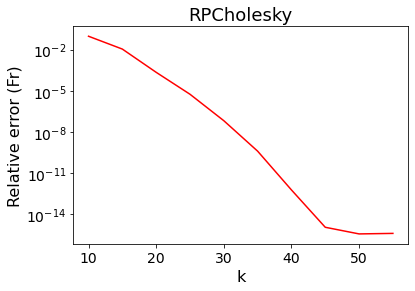

In [21]:
err = []
klst = range(10,70,5)
for k in klst:
    F, ind = rpcholesky(A, k, method = 'greedy')
    err_ = np.linalg.norm(F @ F.T  -A, 'fro')/np.linalg.norm(A, 'fro')
    err.append(err_)

plt.semilogy(klst, err, 'r-')
plt.xlabel('k', fontsize=16)
plt.ylabel('Relative error (Fr)', fontsize=16)
plt.title('RPCholesky', fontsize = 18)


### Machine learning dataset: Abalone

In [22]:

from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import pairwise_distances

# fetch dataset 
abalone = fetch_ucirepo(id=1)
  
# data (as pandas dataframes) 
X = abalone.data.features.to_numpy()[:,1:]
xmax = np.max(X, axis=0)
X = X @ np.diag(1./xmax)
y = abalone.data.targets.to_numpy()

ns = 1500
sigma = 0.3

R = pairwise_distances(X[:ns,:])
KXX = np.exp(-(R/sigma)**2.)


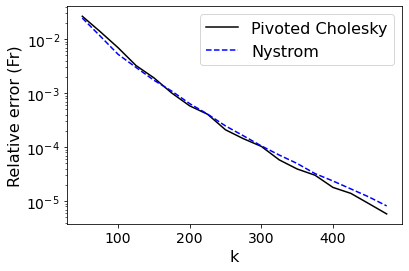

In [23]:
err_rp =[]
err_ny = []
klst = range(50,500,25)
for k in klst:
    F, ind = rpcholesky(KXX, k, method = 'rand')
    err_rp.append(np.linalg.norm(F @ F.T  - KXX, 'fro')/np.linalg.norm(A, 'fro') )
    Omega = np.random.randn(ns, k+10)
    u, l = nystrom_proj(KXX, Omega, k)
    err_ = np.linalg.norm(u @ np.diag(l) @ u.T -KXX, 'fro')/np.linalg.norm(A, 'fro')
    err_ny.append(err_)

plt.semilogy(klst, err_rp, 'k-', klst, err_ny, 'b--')
plt.xlabel('k', fontsize=16)
plt.ylabel('Relative error (Fr)', fontsize=16)
plt.legend(('Pivoted Cholesky', 'Nystrom'), fontsize=16)